데이터셋 폴더로 경로 이동

In [1]:
cd ..

/home


In [2]:
cd ..

/


In [3]:
cd ./disk1/colonoscopy_datasetv2

/disk1/colonoscopy_datasetv2


In [4]:
pwd

'/disk1/colonoscopy_datasetv2'

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [6]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
# 모듈 import
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torchvision import transforms

In [8]:
print(torch.cuda.is_available())

True


Custom DataLoader 구현 - mask 이미지는 제외

In [9]:
# Dataset 한번에 불러오는 코드
class CustomDataset(Dataset):
    def readData(self):
        all_files_path = []
        all_labels = []
        
        class_names = os.walk(self.dataset_path).__next__()[1]

        for idx, class_name in enumerate(class_names):
            img_dir = os.path.join(self.dataset_path, class_name)
            img_file_names = os.walk(img_dir).__next__()[2]

            for img_name in img_file_names:
                # masked 이미지는 제외
                if img_name[4:8] == 'MASK':
                    continue

                img_file_path = os.path.join(img_dir, img_name)
                image = Image.open(img_file_path)

                if image is not None:
                    all_files_path.append(img_file_path)
                    all_labels.append(idx)

        return all_files_path, all_labels, len(all_labels), len(class_names)
            
    def __init__(self, dataset_path, transforms=None):
        self.dataset_path = dataset_path
        self.files_path, self.labels, self.num_files, self.num_classes = self.readData()
        self.transforms = transforms

    def __getitem__(self, index):
        image = Image.open(self.files_path[index])
        label = self.labels[index]
        image = image.convert("RGB")

        if self.transforms is not None:
            image = self.transforms(image)
        
        return {'image': image, 'label': label}

    def __len__(self):
        return self.num_files

Custom DataLoader 확인

In [10]:
sample_class_names = os.walk("./cropped").__next__()[1]
print(sample_class_names)

['NOR', 'ADC', 'HGD', 'LGD']


In [19]:
sample_transforms = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])                                  
sample_dataset = CustomDataset("./cropped", transforms=sample_transforms)
sample_loader = DataLoader(sample_dataset, batch_size=1, shuffle=True)

Dataset 구성 확인 - masked image는 제외한 데이터

In [10]:
total = 0
num_nor0 = 0
num_adc1 = 0
num_hgd2 = 0
num_lgd3 = 0

for idx, item in enumerate(sample_dataset):
    label = item['label']
    if label==0: num_nor0 += 1
    elif label==1: num_adc1 += 1
    elif label==2: num_hgd2 += 1
    elif label==3: num_lgd3 += 1

print("ADC: ", num_adc1, "\nHGD: ", num_hgd2, "\nLGD: ", num_lgd3, "\nNOR: ", num_nor0)


NameError: name 'sample_dataset' is not defined

데이터 시각화

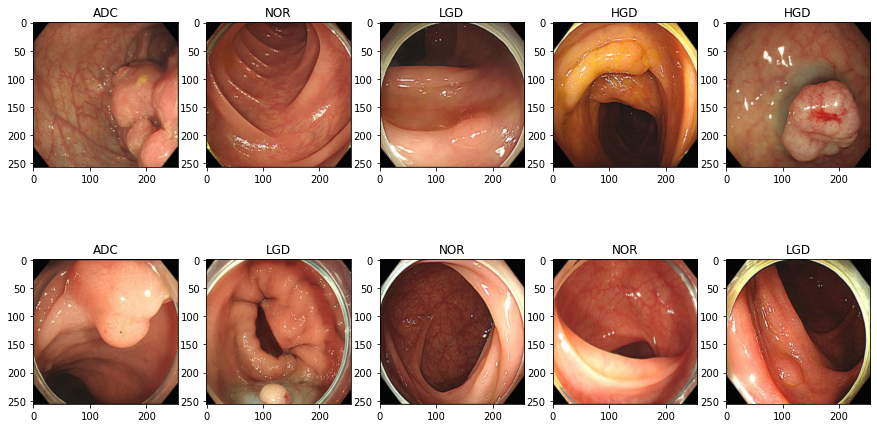

In [21]:
import matplotlib.pyplot as plt

to_image = transforms.ToPILImage()
cnt = 0
plt.figure(figsize=(15,8))
for item in sample_loader:
    if(cnt==10):
        break
    images = item['image']
    labels = item['label']
    class_name = ''

    if labels==0:
        class_name = 'NOR'
    elif labels==1:
        class_name = 'ADC'
    elif labels==2:
        class_name = 'HGD'
    else:
        class_name = 'LGD'

    images = to_image(images[0])

    
    plt.subplot(2,5,cnt+1)
    plt.title(class_name)
    plt.imshow(images)
    cnt+=1
    

Custom CNN network 구현1 - 얼굴 이진 분류 모델에 사용했던 네트워크

In [11]:
class CustomCNN_net1(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN_net1, self).__init__()

        self.num_classes = num_classes
        self.layer1 = self.conv_module(3,16)
        self.layer2 = self.conv_module(16,32)
        self.layer3 = self.conv_module(32,64)
        self.layer4 = self.conv_module(64,128)
        self.layer5 = self.conv_module(128,256)
        self.gap = self.global_avg_pooling(256,num_classes)
        # self.softmax = nn.Softmax()

    def conv_module(self, in_num, out_num):
        output = nn.Sequential(nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(out_num),
                            nn.LeakyReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2))

        return output

    def global_avg_pooling(self, in_num, out_num):
        output = nn.Sequential(nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(out_num),
                            nn.LeakyReLU(),
                            nn.AdaptiveAvgPool2d((1,1)))

        return output

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.gap(out)
        out = out.view(-1,self.num_classes)
        # out = self.softmax(out)

        return out

모듈 구현

In [12]:
def train_epoch(dataloader, model, optimizer, device):
    model.train() # set the model in training mode
    sum_loss = 0
    crit = nn.CrossEntropyLoss()

    for i_batch, item in enumerate(dataloader):

        images = item['image'].to(device)
        labels = item['label'].to(device)

        # forward
        outputs = model(images)
        loss = crit(outputs, labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sum_loss += loss.item() * len(images)
    
    return sum_loss / len(dataloader.dataset)

def validate_epoch(dataloader, model, device):
    model.eval()
    sum_loss = 0
    crit = nn.CrossEntropyLoss()

    with torch.no_grad():
        for item in dataloader:
            images = item['image'].to(device)
            labels = item['label'].to(device)

            outputs = model(images)
            loss = crit(outputs, labels)

            sum_loss += loss.item() * len(images)

    return sum_loss / len(dataloader.dataset)

모델 훈련을 위한 데이터셋 분할

In [13]:
# 데이터셋 불러오기
from configparser import Interpolation


dataset_transforms = transforms.Compose([transforms.Resize((256,256), interpolation=transforms.InterpolationMode.BILINEAR), transforms.ToTensor()])
total_dataset = CustomDataset("./cropped", transforms=dataset_transforms)

# train, validation, test set 분할
dataset_size = total_dataset.num_files
train_size = int(dataset_size*0.8)
validation_size = int(dataset_size*0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(total_dataset, [train_size, validation_size, test_size])
num_classes = total_dataset.num_classes

print("training data size: {}".format(train_size))
print("validation data size: {}".format(validation_size))
print("test data size: {}".format(test_size))


training data size: 2401
validation data size: 300
test data size: 301


데이터셋 분할 확인

In [17]:
train_dataset[0]['image']

tensor([[[0.0275, 0.0275, 0.0275,  ..., 0.0235, 0.0235, 0.0235],
         [0.0275, 0.0275, 0.0275,  ..., 0.0235, 0.0235, 0.0235],
         [0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
         ...,
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0078, 0.0157, 0.0157,  ..., 0.0118, 0.0118, 0.0118],
         [0.0157, 0.0078, 0.0078,  ..., 0.0118, 0.0118, 0.0118]],

        [[0.0275, 0.0275, 0.0275,  ..., 0.0235, 0.0235, 0.0235],
         [0.0275, 0.0275, 0.0275,  ..., 0.0235, 0.0235, 0.0235],
         [0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
         ...,
         [0.0196, 0.0196, 0.0196,  ..., 0.0196, 0.0196, 0.0196],
         [0.0157, 0.0235, 0.0235,  ..., 0.0196, 0.0196, 0.0196],
         [0.0235, 0.0157, 0.0157,  ..., 0.0196, 0.0196, 0.0196]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0157, 0.0157, 0.0157],
         [0.0196, 0.0196, 0.0196,  ..., 0.0157, 0.0157, 0.0157],
         [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.

모델 훈련

In [15]:
# 하이퍼파라미터 설정
hyper_epoch = 80
hyper_lr = 0.0001
hyper_batch = 32

# 모델 선언
train_loader = DataLoader(train_dataset, batch_size=hyper_batch, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=hyper_batch, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=hyper_batch, shuffle=True)

model = CustomCNN_net1(num_classes)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=hyper_lr)


In [ ]:
import torchsummary

torchsummary.summary(model,(3,256,256))

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# 모델 저장
# PATH = '../../home/bokyoungk/classification_models/net1/'

# model = torch.load(PATH+'min_model_21th.pt')
# model.load_state_dict(torch.load(PATH+'min_model_state_dict_21th.pt'))
# checkpoint = torch.load(PATH+'min_all_21th.tar')
# model.load_state_dict(checkpoint['model'])
# optimizer.load_state_dict(checkpoint['optimizer'])

# Training
# minimal_loss = 1

train_loss_list = []
validation_loss_list = []

for e in range(0,hyper_epoch):
    print("---------------------epoch no: {}------------------------".format(e+1))
    train_loss = train_epoch(train_loader, model, optimizer, device)
    validation_loss = validate_epoch(validation_loader, model, device)
    print("training loss={}".format(train_loss))
    print("validation loss={}".format(validation_loss))
    train_loss_list.append(train_loss)
    validation_loss_list.append(validation_loss)
    
    # 최소 loss epoch 모델 저장
    # if minimal_loss > validation_loss:
    #     minimal_loss = validation_loss
    #     torch.save(model, PATH + 'min_model_{}th.pt'.format(e+1)) # 전체 모델 저장
    #     torch.save(model.state_dict(), PATH + 'min_model_state_dict_{}th.pt'.format(e+1))
    #     torch.save({
    #         'model':model.state_dict(),
    #         'optimizer':optimizer.state_dict()
    #     }, PATH+'min_all_{}th.tar'.format(e+1))


---------------------epoch no: 1------------------------


/home/bokyoungk/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


training loss=1.2374965948941359
validation loss=1.2517159048716227
---------------------epoch no: 2------------------------
training loss=1.228201158540242
validation loss=1.2425998210906983
---------------------epoch no: 3------------------------
training loss=1.2216900901861958
validation loss=1.2165579875310262
---------------------epoch no: 4------------------------
training loss=1.2157539868543468
validation loss=1.2485189549128215
---------------------epoch no: 5------------------------
training loss=1.2072599947030522
validation loss=1.2344048166275023
---------------------epoch no: 6------------------------
training loss=1.2004646765396327
validation loss=1.1852365843454997
---------------------epoch no: 7------------------------
training loss=1.196900795768172
validation loss=1.2288902521133422
---------------------epoch no: 8------------------------
training loss=1.1895090712452372
validation loss=1.1997298701604207
---------------------epoch no: 9------------------------
tr

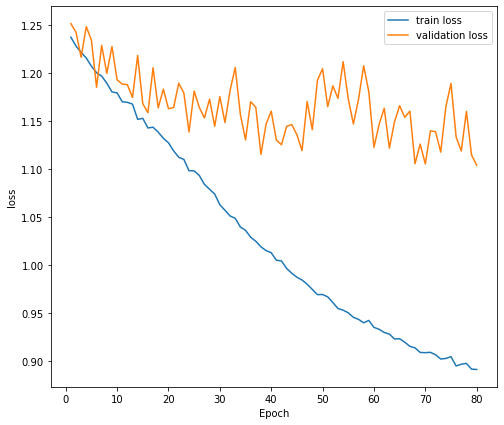

In [17]:
# loss 그래프
x = np.arange(1,hyper_epoch+1,step=1)
plt.figure(figsize=(8,7))
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.plot(x,train_loss_list,label='train loss')
plt.plot(x,validation_loss_list, label='validation loss')
plt.legend()
plt.show()

In [31]:
PATH = '../../home/bokyoungk/classification_models/net1/'
model_n = 'min_model_57th.pt'
model_st = 'min_model_state_dict_57th.pt'
model_all = 'min_all_57th.tar'

model = torch.load(PATH + model_n)
model.load_state_dict(torch.load(PATH+model_st))

checkpoint = torch.load(PATH+model_all)
model.load_state_dict(checkpoint['model'])


# Inference
model.eval()
with torch.no_grad():
    correct = 0
    total = 0

    for item in test_loader:
        images = item['image'].to(device)
        labels = item['label'].to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += len(labels)
        correct += (predicted==labels).sum().item()
        

print('Test Accuracy of the model on the {} test images: {}%'.format(total, 100 * correct / total))

Test Accuracy of the model on the 301 test images: 97.00996677740864%
